In [20]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers

# from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

import matplotlib.pyplot as plt

from bobs import learn, plots

In [4]:
mnist = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [5]:
def preprocess_x(x):
    return np.expand_dims(x, -1) / 255

In [6]:
def preprocess_y(y):
    return keras.utils.to_categorical(y, num_classes=10)

In [7]:
(train_x, train_y), (test_x, test_y) = mnist
train_x = preprocess_x(train_x)
test_x = preprocess_x(test_x)
train_y = preprocess_y(train_y)
test_y = preprocess_y(test_y)

In [8]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [9]:
def show_labelled_image(image, label, predicted_label=None, predicted_confidence=None):
    show_image(image)
    title = f'Digit {list(label).index(1)}'
    if predicted_label is not None:
        title += f', prediction is {predicted_label}'
        if predicted_confidence is not None:
            title += f' with {predicted_confidence:.0%} confidence'
    plt.title(title)

In [10]:
def show_train_example(i):
    show_labelled_image(train_x[i], train_y[i])

In [11]:
def show_test_example(i):
    show_labelled_image(test_x[i], test_y[i])

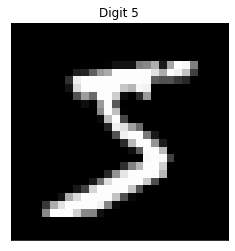

In [12]:
show_train_example(0)

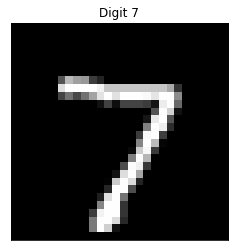

In [13]:
show_test_example(0)

In [14]:
def build_model():
    model = models.Sequential(name='cnn')
    model.add(layers.Input((28, 28, 1), name='input'))
    model.add(
        layers.Conv2D(
            64, 8, strides=(2, 2),
            activation='relu', padding='same',
            name='conv1',
        )
    )
    model.add(
        layers.Conv2D(
            128, 6, strides=(2, 2),
            activation='relu', padding='valid',
            name='conv2',
        )
    )
    model.add(
        layers.Conv2D(
            128, 5, strides=(1, 1),
            activation='relu', padding='valid',
            name='conv3'
        )
    )
    model.add(layers.Dropout(0.25, name='dropout'))
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(128, activation='relu', name='hidden'))
    model.add(layers.Dense(10, activation='softmax', name='output'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [15]:
build_model().summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 64)        4160      
_________________________________________________________________
conv2 (Conv2D)               (None, 5, 5, 128)         295040    
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 1, 128)         409728    
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
hidden (Dense)               (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 10)                1290    

In [16]:
def build_and_train():
    model = build_model()
    model.fit(
        train_x, train_y,
        epochs=10, batch_size=100,
        validation_data=(test_x, test_y)
    )
    return model

In [21]:
model = learn.load_or_train(
    'victim/2/', build_and_train, method='tensorflow'
)

Epoch 1/10
600/600 [==============================] - 40s 67ms/step - loss: 0.4430 - accuracy: 0.8587 - val_loss: 0.0908 - val_accuracy: 0.9703
Epoch 2/10
600/600 [==============================] - 40s 66ms/step - loss: 0.0665 - accuracy: 0.9792 - val_loss: 0.0377 - val_accuracy: 0.9892
Epoch 3/10
600/600 [==============================] - 40s 67ms/step - loss: 0.0404 - accuracy: 0.9875 - val_loss: 0.0392 - val_accuracy: 0.9879
Epoch 4/10
600/600 [==============================] - 40s 66ms/step - loss: 0.0339 - accuracy: 0.9899 - val_loss: 0.0365 - val_accuracy: 0.9890
Epoch 5/10
600/600 [==============================] - 41s 68ms/step - loss: 0.0269 - accuracy: 0.9914 - val_loss: 0.0352 - val_accuracy: 0.9897
Epoch 6/10
600/600 [==============================] - 40s 67ms/step - loss: 0.0199 - accuracy: 0.9938 - val_loss: 0.0373 - val_accuracy: 0.9889
Epoch 7/10
600/600 [==============================] - 40s 66ms/step - loss: 0.0168 - accuracy: 0.9944 - val_loss: 0.0362 - val_accuracy:

In [22]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 3s 8ms/step - loss: 0.0454 - accuracy: 0.9903


[0.045427676290273666, 0.9902999997138977]

In [38]:
pred = np.argmax(model.predict(test_x), axis=1)

In [43]:
test_labels = [list(y).index(1) for y in test_y]

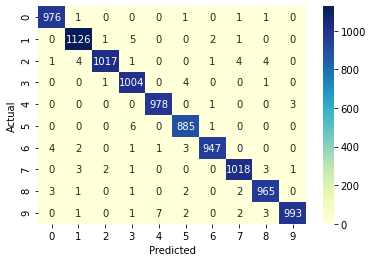

In [44]:
plots.confusionplot(test_labels, pred, labels=list(range(10)))

In [17]:
attack = projected_gradient_descent(
    model, test_x,
    eps=0.3,
    eps_iter=0.01,
    nb_iter=40,
    norm=np.inf,
    targeted=False,
)

In [18]:
def show_attack_image(attack, i):
    probs = model.predict(attack[i : i + 1])[0]
    pred_label = np.argmax(probs)
    confidence = probs[pred_label]
    show_labelled_image(attack[i], test_y[i], pred_label, confidence)

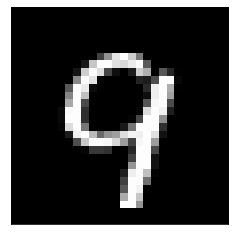

In [53]:
show_image(test_x[16])
plt.savefig('plain_digit.png')

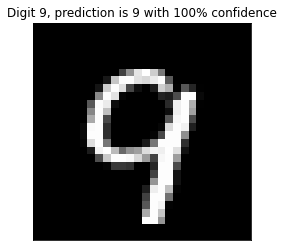

In [19]:
show_attack_image(test_x, 16)

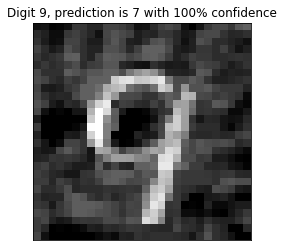

In [20]:
show_attack_image(attack, 16)

In [21]:
attack_pred = np.argmax(model.predict(attack), axis=1)

In [22]:
successful_attacks = (pred != attack_pred).nonzero()[0]

In [23]:
len(successful_attacks)

9909

In [24]:
successful_attacks[:20]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

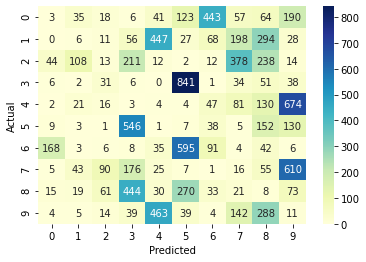

In [45]:
plots.confusionplot(test_labels, attack_pred, labels=list(range(10)))

In [26]:
attack2 = projected_gradient_descent(
    model, test_x,
    eps=0.3,
    eps_iter=0.01,
    nb_iter=10,
    norm=np.inf,
    
)

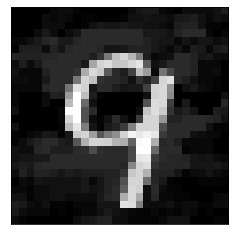

In [55]:
show_image(attack2[16])
plt.savefig('attack_digit.png')

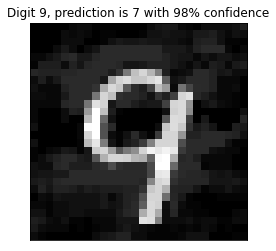

In [27]:
show_attack_image(attack2, 16)

In [28]:
attack2_pred = np.argmax(model.predict(attack2), axis=1)

In [29]:
successful_attacks2 = (pred != attack2_pred).nonzero()[0]

In [30]:
len(successful_attacks2)

7363

In [31]:
successful_attacks2[:20]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 14, 15, 16, 17, 18,
       19, 20, 21])

In [32]:
model.predict(attack2[16:17])

array([[1.4533756e-04, 2.3092858e-03, 8.9808623e-04, 3.3129219e-04,
        6.5970011e-03, 1.8445212e-04, 4.3198019e-05, 9.7950953e-01,
        2.6807683e-03, 7.3010693e-03]], dtype=float32)

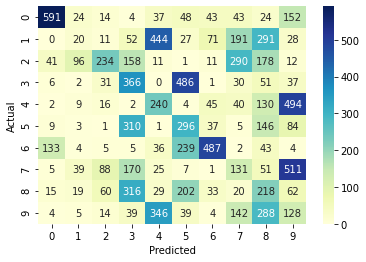

In [46]:
plots.confusionplot(test_labels, attack2_pred, labels=list(range(10)))

In [59]:
model.evaluate(attack2, test_y)

313/313 [==============================] - 2s 6ms/step - loss: 7.2958 - accuracy: 0.2711


[7.29580545425415, 0.2711000144481659]